Mounted at /content/drive


<ipython-input-1-cea594ef6c7d>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('/content/drive/My Drive/Colab Notebooks/Proyecto/train_loader.pt'

Primer batch en train_loader: inputs: torch.Size([32, 17]), labels: torch.Size([32, 1])
Primer batch en val_loader: inputs: torch.Size([32, 17]), labels: torch.Size([32, 1])
Primer batch en test_loader: inputs: torch.Size([32, 17]), labels: torch.Size([32, 1])
Dispositivo utilizado: cuda
Época [1/50], Pérdida Entrenamiento: 0.6731, Pérdida Validación: 0.4886
Mejor modelo guardado con pérdida de validación: 0.4886
Época [2/50], Pérdida Entrenamiento: 0.4782, Pérdida Validación: 0.3982
Mejor modelo guardado con pérdida de validación: 0.3982
Época [3/50], Pérdida Entrenamiento: 0.4316, Pérdida Validación: 0.4080
Patience counter: 1/5
Época [4/50], Pérdida Entrenamiento: 0.4085, Pérdida Validación: 0.3775
Mejor modelo guardado con pérdida de validación: 0.3775
Época [5/50], Pérdida Entrenamiento: 0.3748, Pérdida Validación: 0.3500
Mejor modelo guardado con pérdida de validación: 0.3500
Época [6/50], Pérdida Entrenamiento: 0.3574, Pérdida Validación: 0.3255
Mejor modelo guardado con pérdida

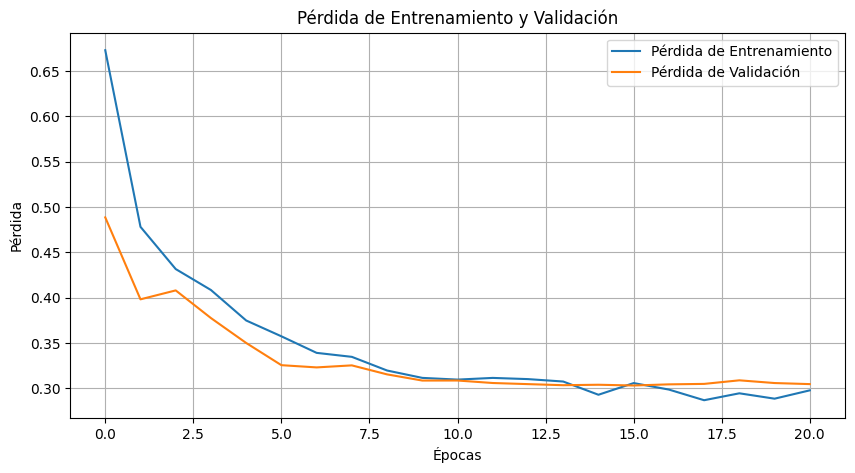

Mejor modelo guardado correctamente en /content/drive/My Drive/Colab Notebooks/Proyecto/best_model_fc.pth


In [1]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import json

# Montar Google Drive
drive.mount('/content/drive')

# Cargar DataLoaders desde Google Drive
train_loader = torch.load('/content/drive/My Drive/Colab Notebooks/Proyecto/train_loader.pt')
val_loader = torch.load('/content/drive/My Drive/Colab Notebooks/Proyecto/val_loader.pt')
test_loader = torch.load('/content/drive/My Drive/Colab Notebooks/Proyecto/test_loader.pt')

# Verificar el tipo y contenido de los DataLoaders
for loader, name in zip([train_loader, val_loader, test_loader], ['train', 'val', 'test']):
    for i, (inputs, labels) in enumerate(loader):
        print(f"Primer batch en {name}_loader: inputs: {inputs.shape}, labels: {labels.shape}")
        break

# Verificar si GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Definir la red neuronal
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return torch.tanh(x)  # Activación Tanh en la capa de salida


input_size = next(iter(train_loader))[0].shape[1]
hidden_size1, hidden_size2, output_size = 32, 16, 1
model = NeuralNet(input_size, hidden_size1, hidden_size2, output_size).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# variables de entrenamiento
epochs = 50
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, patience_counter = 5, 0
best_model_path = '/content/drive/My Drive/Colab Notebooks/Proyecto/best_model_fc.pth'

# listas para almacenar las salidas del modelo
train_outputs, val_outputs, train_targets, val_targets = [], [], [], []

# Entrenamiento
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)

        # Guardar
        train_outputs.append(outputs.cpu().detach().numpy())
        train_targets.append(targets.cpu().detach().numpy())


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Guardar
            val_outputs.append(outputs.cpu().detach().numpy())
            val_targets.append(targets.cpu().detach().numpy())

    # Calcular pérdidas
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Época [{epoch+1}/{epochs}], Pérdida Entrenamiento: {train_loss:.4f}, "
          f"Pérdida Validación: {val_loss:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Mejor modelo guardado con pérdida de validación: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{patience}")


    if patience_counter >= patience:
        print("Deteniendo entrenamiento por Early Stopping...")
        break

# Guardar las salidas y etiquetas
np.save('/content/drive/My Drive/Colab Notebooks/Proyecto/train_outputs_fc.npy', np.concatenate(train_outputs, axis=0))
np.save('/content/drive/My Drive/Colab Notebooks/Proyecto/val_outputs_fc.npy', np.concatenate(val_outputs, axis=0))
np.save('/content/drive/My Drive/Colab Notebooks/Proyecto/train_targets_fc.npy', np.concatenate(train_targets, axis=0))
np.save('/content/drive/My Drive/Colab Notebooks/Proyecto/val_targets_fc.npy', np.concatenate(val_targets, axis=0))


plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.grid()
plt.show()

# Verificar si el mejor modelo fue guardado correctamente
if os.path.exists(best_model_path):
    print(f"Mejor modelo guardado correctamente en {best_model_path}")
else:
    print("Error: No se pudo guardar el mejor modelo.")


<ipython-input-2-3a9a76d79903>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Pérdida en el conjunto de prueba: 0.2923


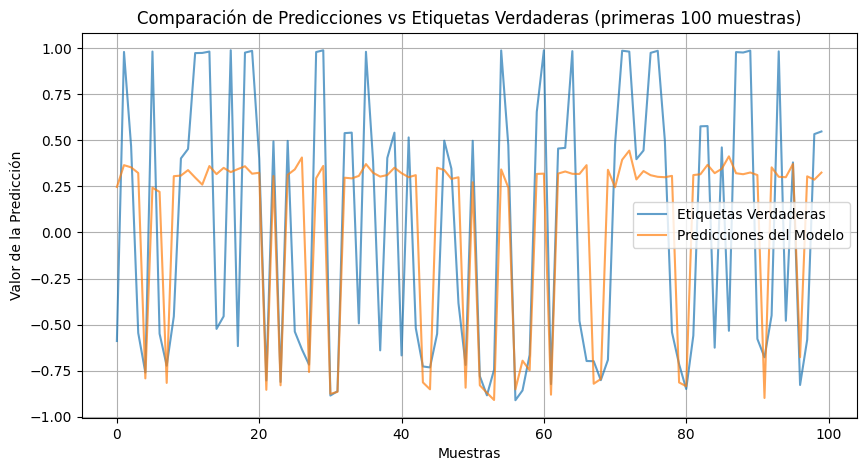

In [2]:
# Cargar el mejor modelo guardado
model.load_state_dict(torch.load(best_model_path))
model.eval()  #  modo evaluación

#las listas para almacenar las salidas y las etiquetas de test
test_outputs, test_targets = [], []


test_loss = 0.0
with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Guardar las salidas y etiquetas
        test_outputs.append(outputs.cpu().detach().numpy())
        test_targets.append(targets.cpu().detach().numpy())

test_loss /= len(test_loader)


print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

# Guardar las salidas y etiquetas en archivos .npy
np.save('/content/drive/My Drive/Colab Notebooks/Proyecto/test_outputs_fc.npy', np.concatenate(test_outputs, axis=0))
np.save('/content/drive/My Drive/Colab Notebooks/Proyecto/test_targets_fc.npy', np.concatenate(test_targets, axis=0))

# ejemplo:
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(test_targets[:100], label='Etiquetas Verdaderas', alpha=0.7)
plt.plot(test_outputs[:100], label='Predicciones del Modelo', alpha=0.7)
plt.xlabel('Muestras')
plt.ylabel('Valor de la Predicción')
plt.title('Comparación de Predicciones vs Etiquetas Verdaderas (primeras 100 muestras)')
plt.legend()
plt.grid()
plt.show()
